# Trend Analysis: 
  
Katie Brennan  
Started September 2020  

In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import pickle
import xarray as xr

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
plt.rcParams['figure.dpi']=300

In [4]:
def plot_hist_pre_post_sat_test(pre_industrial_trends, post_industrial_trends, sat_trends, 
                           percentile_low, percentile_high, start_year, binwidth, ax_hist,
                           palette = 'blues',strends=False): 
    hist_kwargs = dict(histtype='step',linewidth=1.5)
    
    if palette in ['blues']:
        c0 = '#6488ea' #'soft blue'
        c1 = '#a2bffe' #'pastel blue'
        c2 = 'navy'
        c3 = 'c'
        #b1d1fc
    elif palette in ['purples']: 
#        c0 = '#8d5eb7' #deep lavender
        c0 = '#a87dc2' #'wisteria'
        c1 = '#c79fef' #'lavender'
        c2 = 'indigo'
        c3 = 'mediumorchid'
    else:
        c1 = 'darkcyan'
        c2 = 'darkslategray'
        c3 = 'c'

    bins_hold = np.arange(min(pre_industrial_trends),max(pre_industrial_trends) + binwidth, binwidth)
    
    N, bins, patches = ax_hist.hist(pre_industrial_trends,facecolor=c0,edgecolor=c0,
                                    fill=True,density=True,bins=bins_hold,linewidth=1,zorder=0,
                                    label='Reconstructed \ntrends ('+str(start_year)+'-1850)')
    ax_hist.hist(post_industrial_trends,edgecolor=c2,density=True,
                 alpha=0.9,label='Reconstructed \ntrends (1850-1979)',
                 bins=np.arange(min(post_industrial_trends),max(post_industrial_trends) + binwidth, binwidth), 
                 zorder=2,**hist_kwargs)
    ax_hist.hist(sat_trends,edgecolor=c3,density=True,
                 facecolor=c3,alpha=0.9,label='Reconstructed \ntrends(1979-2000)',
                 bins=np.arange(min(sat_trends),max(sat_trends) + binwidth, binwidth),
                 zorder=3,**hist_kwargs)
    
    pbin_low = np.percentile(pre_industrial_trends,percentile_low)
    pbin_high = np.percentile(pre_industrial_trends,percentile_high)
    bins_percentile_low = np.where((bins<=pbin_low))
    bins_percentile_high = np.where(bins>=pbin_high)

    for i in bins_percentile_low[0]:
        patches[i].set_facecolor(c1)
        patches[i].set_edgecolor(c1)  
        
    for i in bins_percentile_high[0][:-1]:
        patches[i].set_facecolor(c1)
        patches[i].set_edgecolor(c1)

    if strends is True: 
        ax_hist.axvline(np.mean(sat_trends),linestyle='--',color=c3,linewidth=2.5)

    return 

def calc_all_trends(length, start_time, end_time, timeseries, timeseries_time): 
    """
    inputs:
    -------------
    length = integer value
    start_time = integer, start year
    end_time = integer, end year
    timeseries = 2D array (time, nens)
    timeseries_time = array, years (time)
    """
    start_range = np.arange(start_time,end_time-length,1)
    end_range = np.arange(start_time+length,end_time,1)
    
    slope_all_recon = []

    for it in range(timeseries.shape[1]):
        hold = np.zeros((len(start_range)))
        if np.remainder(it,100) == 0:  
            print(str(it)+' of '+str(timeseries.shape[1]))
            
        for t in range(len(start_range)):
            hold[t] = find_trend(timeseries[:,it],timeseries_time,
                                 start_range[t],end_range[t])
        slope_all_recon.append(hold)
        
    slope_all_endpts = np.array(slope_all_recon).flatten()   
    
    return slope_all_endpts

def load_annual_satellite_anom(ANOM_END): 
    """Loads annual satellite data and finds anomalies that start at 1979 and go 
       to ANOM_END. 
    """
    # Import satellite data Fetterer v3: 
    fet_directory = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/Fetterer_v3/'
    #fet_file = 'Fetterer_data_v3_annual_1978_2017.npz'
    fet_file = 'Fetterer_data_v3_annual_78_17.npz'

    # Load annual data
    fet_loc = fet_directory + fet_file
    fet_data = np.load(fet_loc)

    fet_sie = fet_data['si_extent'][1:]
    fet_sia = fet_data['si_area'][1:]
    fet_sia_adj = fet_data['si_area_adj']
    fet_time = fet_data['time'][1:]

    # Find anomalies: 

    # Calculate mean 
    fet_anom_cent_sia = np.nanmean(fet_sia[np.where(fet_time<=ANOM_END)],axis=0)
    fet_anom_cent_sia_adj = np.nanmean(fet_sia_adj[np.where(fet_time[1:]<=ANOM_END)],axis=0)
    fet_anom_cent_sie = np.nanmean(fet_sie[np.where(fet_time<=ANOM_END)],axis=0)

    # Find anomalies:  
    fet_sia_anom = fet_sia - fet_anom_cent_sia
    fet_sia_anom_adj = fet_sia_adj - fet_anom_cent_sia_adj
    fet_sie_anom = fet_sie - fet_anom_cent_sie
    
    return fet_sia_anom, fet_sia_anom_adj, fet_sie_anom, fet_time

def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

def load_mpi_lm_regridded():
    mpi_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/MPI/'
    mpi_file = 'mpi_sic_sit_tas_20CRv2_850_1850_full.npz'

    mpi_lm = np.load(mpi_dir+mpi_file)

    mpi_truth_sic = mpi_lm['sic_mpi']
    mpi_truth_sit = mpi_lm['sit_mpi']
    mpi_truth_tas = mpi_lm['tas_mpi']
    mpi_truth_lat = mpi_lm['lat_mpi']
    mpi_truth_lon = mpi_lm['lon_mpi']
    
    return mpi_truth_tas, mpi_truth_sic, mpi_truth_sit, mpi_truth_lat, mpi_truth_lon

def calc_lm_tot_si(truth_sic,truth_lat,truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo= calc_sea_ice_extent(truth_sic,15.0)

    _,nh_sic_truth,sh_sic_truth = global_hemispheric_means(truth_sic,truth_lat[:,0])
    _,nh_sie_truth,sh_sie_truth = global_hemispheric_means(sie_lalo,truth_lat[:,0])
    sia_nh_truth = nh_sic_truth*nharea
    sie_nh_truth = nh_sie_truth*nharea
    sia_sh_truth = sh_sic_truth*nharea
    sie_sh_truth = sh_sie_truth*nharea
    
    anom_int = np.where((truth_time>=anom_start)&(truth_time<=anom_end+1))

    sia_nh_truth_anom = sia_nh_truth - np.nanmean(sia_nh_truth[anom_int])
    sie_nh_truth_anom = sie_nh_truth - np.nanmean(sie_nh_truth[anom_int])
    sia_sh_truth_anom = sia_sh_truth - np.nanmean(sia_sh_truth[anom_int])
    sie_sh_truth_anom = sie_sh_truth - np.nanmean(sie_sh_truth[anom_int])
    
    return [sia_nh_truth, sie_nh_truth, sia_nh_truth_anom, sie_nh_truth_anom,
            sia_sh_truth, sie_sh_truth, sia_sh_truth_anom, sie_sh_truth_anom]

def calc_sea_ice_extent(SIC, CUTOFF):
    """Calculates the sea ice extent from concentration values

    SIC = sea ice concentration values (%), full field not anomalies (time,lat,lon)
    CUTOFF = values below this cutoff will be set to zero (%)
    """
    if np.nanmax(SIC)> 1.0:
        sic_nonan = SIC
        sic_nonan[np.isnan(sic_nonan)]=0.0
        sie = np.where(sic_nonan <= CUTOFF,0.0,100)
    elif np.nanmax(SIC) <=1.0:
        sic_nonan = SIC
        sic_nonan[np.isnan(sic_nonan)]=0.0
        sie = np.where(sic_nonan <= CUTOFF/100.0,0.0,1.0)

    return sie

def global_hemispheric_means(field,lat):

    """
     compute global and hemispheric mean valuee for all times in the input (i.e. field) array
     input:  field[ntime,nlat,nlon] or field[nlat,nlon]
             lat[nlat,nlon] in degrees

     output: gm : global mean of "field"
            nhm : northern hemispheric mean of "field"
            shm : southern hemispheric mean of "field"
    """

    # Originator: Greg Hakim
    #             University of Washington
    #             August 2015
    #
    # Modifications:
    #           - Modified to handle presence of missing values (nan) in arrays
    #             in calculation of spatial averages [ R. Tardif, November 2015 ]
    #           - Enhanced flexibility in the handling of missing values
    #             [ R. Tardif, Aug. 2017 ]

    # set number of times, lats, lons; array indices for lat and lon    
    if len(np.shape(field)) == 3: # time is a dimension
        ntime,nlat,nlon = np.shape(field)
        lati = 1
        loni = 2
    else: # only spatial dims
        ntime = 1
        nlat,nlon = np.shape(field)
        field = field[None,:] # add time dim of size 1 for consistent array dims
        lati = 1
        loni = 2

    # latitude weighting 
    lat_weight = np.cos(np.deg2rad(lat))
    tmp = np.ones([nlon,nlat])
    W = np.multiply(lat_weight,tmp).T

    # define hemispheres
    eqind = nlat//2

    if lat[0] > 0:
        # data has NH -> SH format
        W_NH = W[0:eqind+1]
        field_NH = field[:,0:eqind+1,:]
        W_SH = W[eqind+1:]
        field_SH = field[:,eqind+1:,:]
    else:
        # data has SH -> NH format
        W_NH = W[eqind:]
        field_NH = field[:,eqind:,:]
        W_SH = W[0:eqind]
        field_SH = field[:,0:eqind,:]

    gm  = np.zeros(ntime)
    nhm = np.zeros(ntime)
    shm = np.zeros(ntime)

    # Check for valid (non-NAN) values & use numpy average function (includes weighted avg calculation) 
    # Get arrays indices of valid values
    indok    = np.isfinite(field)
    indok_nh = np.isfinite(field_NH)
    indok_sh = np.isfinite(field_SH)
    for t in range(ntime):
        if lati == 0:
            # Global
            gm[t]  = np.average(field[indok],weights=W[indok])
            # NH
            nhm[t] = np.average(field_NH[indok_nh],weights=W_NH[indok_nh])
            # SH
            shm[t] = np.average(field_SH[indok_sh],weights=W_SH[indok_sh])
        else:
            # Global
            indok_2d    = indok[t,:,:]
            if indok_2d.any():
                field_2d    = np.squeeze(field[t,:,:])
                gm[t]       = np.average(field_2d[indok_2d],weights=W[indok_2d])
            else:
                gm[t] = np.nan
            # NH
            indok_nh_2d = indok_nh[t,:,:]
            if indok_nh_2d.any():
                field_nh_2d = np.squeeze(field_NH[t,:,:])
                nhm[t]      = np.average(field_nh_2d[indok_nh_2d],weights=W_NH[indok_nh_2d])
            else:
                nhm[t] = np.nan
            # SH
            indok_sh_2d = indok_sh[t,:,:]
            if indok_sh_2d.any():
                field_sh_2d = np.squeeze(field_SH[t,:,:])
                shm[t]      = np.average(field_sh_2d[indok_sh_2d],weights=W_SH[indok_sh_2d])
            else:
                shm[t] = np.nan

    return gm,nhm,shm

def find_trend(VAR, VAR_TIME, START, END, all_output=False):
    """Finds linear trend via regression of a timeseries
    """
    ind = np.where((VAR_TIME>=START)&(VAR_TIME<END+1))

    if all_output is True:
        [slope, intercept, r_value, p_value, std_err] = stats.linregress(VAR_TIME[ind],VAR[ind])
        
        return slope, intercept, r_value, p_value, std_err
    else:
        slope = stats.linregress(VAR_TIME[ind],VAR[ind])[0]
        
        return slope


## Load reconstructions: 

In [5]:
recon_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/data/'
recon_file_ccsm4 = 'Brennan_and_Hakim_2021_CCSM4_model_prior_reconstructions_nh.nc'
recon_file_mpi = 'Brennan_and_Hakim_etal_2021_MPI_model_prior_reconstructions_nh.nc'

recon_data_ccsm4 = xr.open_dataset(recon_dir+recon_file_ccsm4)
recon_data_mpi = xr.open_dataset(recon_dir+recon_file_mpi)

In [6]:
sie_ccsm4_anom = recon_data_ccsm4.si_extent_anomalies.values
sie_ccsm4_anom_2d = np.reshape(sie_ccsm4_anom,(2000,2000))
sie_ensmn_anom_ccsm4 = recon_data_ccsm4.si_extent_ensemble_mean_anomalies.values
sie_ccsm4_97_5_anom = recon_data_ccsm4.si_extent_97_5_percentiles.values
sie_ccsm4_2_5_anom = recon_data_ccsm4.si_extent_2_5_percentiles.values
recon_years = recon_data_ccsm4.time.values

In [7]:
sie_mpi_anom = recon_data_mpi.si_extent_anomalies.values
sie_mpi_anom_2d = np.reshape(sie_mpi_anom,(2000,2000))
sie_ensmn_anom_mpi = recon_data_mpi.si_extent_ensemble_mean_anomalies.values
sie_mpi_97_5_anom = recon_data_mpi.si_extent_97_5_percentiles.values
sie_mpi_2_5_anom = recon_data_mpi.si_extent_2_5_percentiles.values
recon_years_mpi = recon_data_mpi.time.values

## Load Satellite data: 

In [8]:
anom_start = 1979
anom_end = 2000

In [9]:
# LOAD ANNUAL SATELLITE DATA: 
[fet_sia_anom, _, fet_sie_anom, fet_time] = load_annual_satellite_anom(2000)

### Load LM simulations: 

In [10]:
recon_start = 850
recon_end = 1849

In [11]:
[ccsm4_truth_tas, ccsm4_truth_sic,_,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_nh_ccsm4_truth, sie_nh_ccsm4_truth, 
 sia_nh_ccsm4_truth_anom, sie_nh_ccsm4_truth_anom,
 sia_sh_ccsm4_truth, sie_sh_ccsm4_truth, 
 sia_sh_ccsm4_truth_anom, 
 sie_sh_ccsm4_truth_anom] = calc_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                           ccsm4_truth_time, recon_start, recon_end)

In [12]:
[mpi_truth_tas, mpi_truth_sic, _,
 mpi_truth_lat, mpi_truth_lon] = load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_nh_mpi, sie_nh_mpi, 
 sia_nh_mpi_anom, sie_nh_mpi_anom,
 sia_sh_mpi, sie_sh_mpi, 
 sia_sh_mpi_anom, sie_sh_mpi_anom] = calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                    mpi_time, recon_start, recon_end)

### 30-year trends: 

In [13]:
length = 30 

sat_range_start = np.arange(1979,2017-length,1)
sat_range_end = np.arange(1979+length,2017,1)

sat30_slope_all_endpts = np.zeros(len(sat_range_start))

for t,time in enumerate(sat_range_start):
    sat30_slope_all_endpts[t] = find_trend(fet_sie_anom,fet_time,sat_range_start[t],sat_range_end[t])
    
sat30_slope_79_00 = find_trend(fet_sie_anom,fet_time,1979,2000)

In [14]:
pre30_slope_all_endpts_ccsm4 = calc_all_trends(30,1000,1850,sie_ccsm4_anom_2d,recon_years)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [15]:
pre30_slope_all_endpts_mpi = calc_all_trends(30,1000,1850,sie_mpi_anom_2d,recon_years_mpi)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [16]:
post30_slope_all_endpts_ccsm4 = calc_all_trends(30,1850,1979,sie_ccsm4_anom_2d,recon_years)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [17]:
post30_slope_all_endpts_mpi = calc_all_trends(30,1850,1979,sie_mpi_anom_2d,recon_years_mpi)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


### 20-year trends: 

In [19]:
length = 20 

sat_range_start = np.arange(1979,2017-length,1)
sat_range_end = np.arange(1979+length,2017,1)

sat20_slope_all_endpts = np.zeros(len(sat_range_start))

for t,time in enumerate(sat_range_start):
    sat20_slope_all_endpts[t] = find_trend(fet_sie_anom,fet_time,sat_range_start[t],sat_range_end[t])
    
sat20_slope_79_00 = find_trend(fet_sie_anom,fet_time,1979,2000)

In [20]:
pre20_slope_all_endpts_ccsm4 = calc_all_trends(20,1000,1850,sie_ccsm4_anom_2d,recon_years)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [21]:
pre20_slope_all_endpts_mpi = calc_all_trends(20,1000,1850,sie_mpi_anom_2d,recon_years_mpi)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [22]:
post20_slope_all_endpts_ccsm4 = calc_all_trends(20,1850,1979,sie_ccsm4_anom_2d,recon_years)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [23]:
post20_slope_all_endpts_mpi = calc_all_trends(20,1850,1979,sie_mpi_anom_2d,recon_years_mpi)

0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000


In [25]:
sat20_slope_recon_ccsm4 = np.zeros((sie_ccsm4_anom_2d.shape[1]))

for it in range(2000):
    sat20_slope_recon_ccsm4[it] = find_trend(sie_ccsm4_anom_2d[:,it],recon_years,1979,2000)

In [26]:
sat20_slope_recon_mpi = np.zeros((sie_mpi_anom_2d.shape[1]))

for it in range(2000):
    sat20_slope_recon_mpi[it] = find_trend(sie_mpi_anom_2d[:,it],recon_years_mpi,1979,2000)

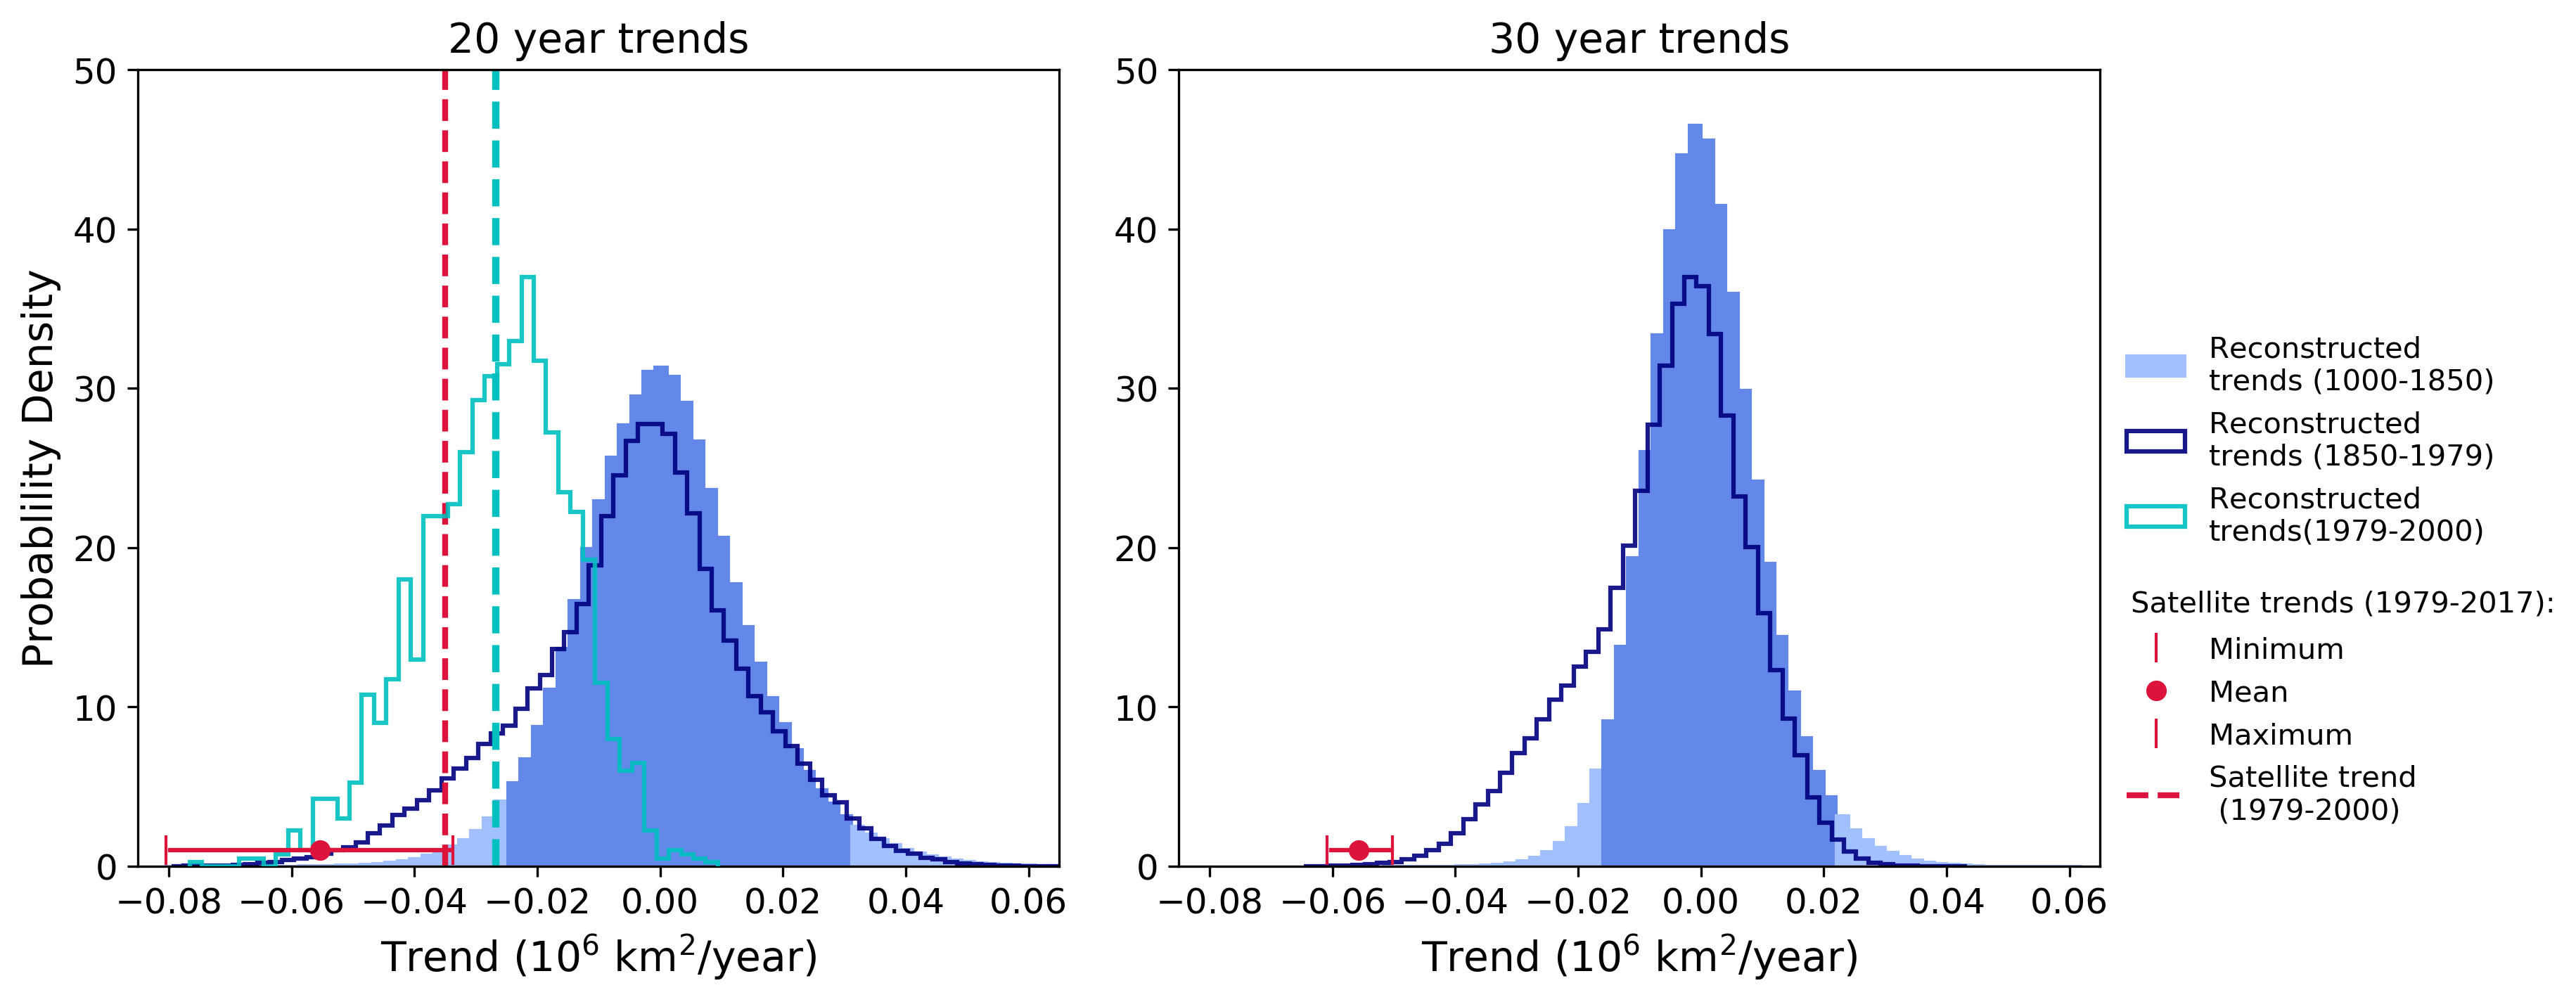

In [27]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat_test(pre20_slope_all_endpts_ccsm4, post20_slope_all_endpts_ccsm4, 
                            sat20_slope_recon_ccsm4,2.5, 97.5, 1000, binwidth, ax_hist[0],
                            palette = 'blues',strends=True)
plot_hist_pre_post_sat_test(pre30_slope_all_endpts_ccsm4, post30_slope_all_endpts_ccsm4, 
                            np.zeros(30), 2.5, 97.5, 1000, binwidth, ax_hist[1],
                            palette = 'blues',strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=2,
                   label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ',zorder=5)
ax_hist[0].axhline(y=1,xmin=0.035,xmax=0.34,color='crimson',linewidth=1.5,zorder=4)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
                markersize=10,linestyle='None',linewidth=2, 
                label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
                markersize=10,linestyle='None',linewidth=2, 
                label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.165,xmax=0.23,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.085,0.065)
ax_hist[0].set_ylim(0,50)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.085,0.065)
ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[7], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[7], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 16,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_ccsm4_shaded.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

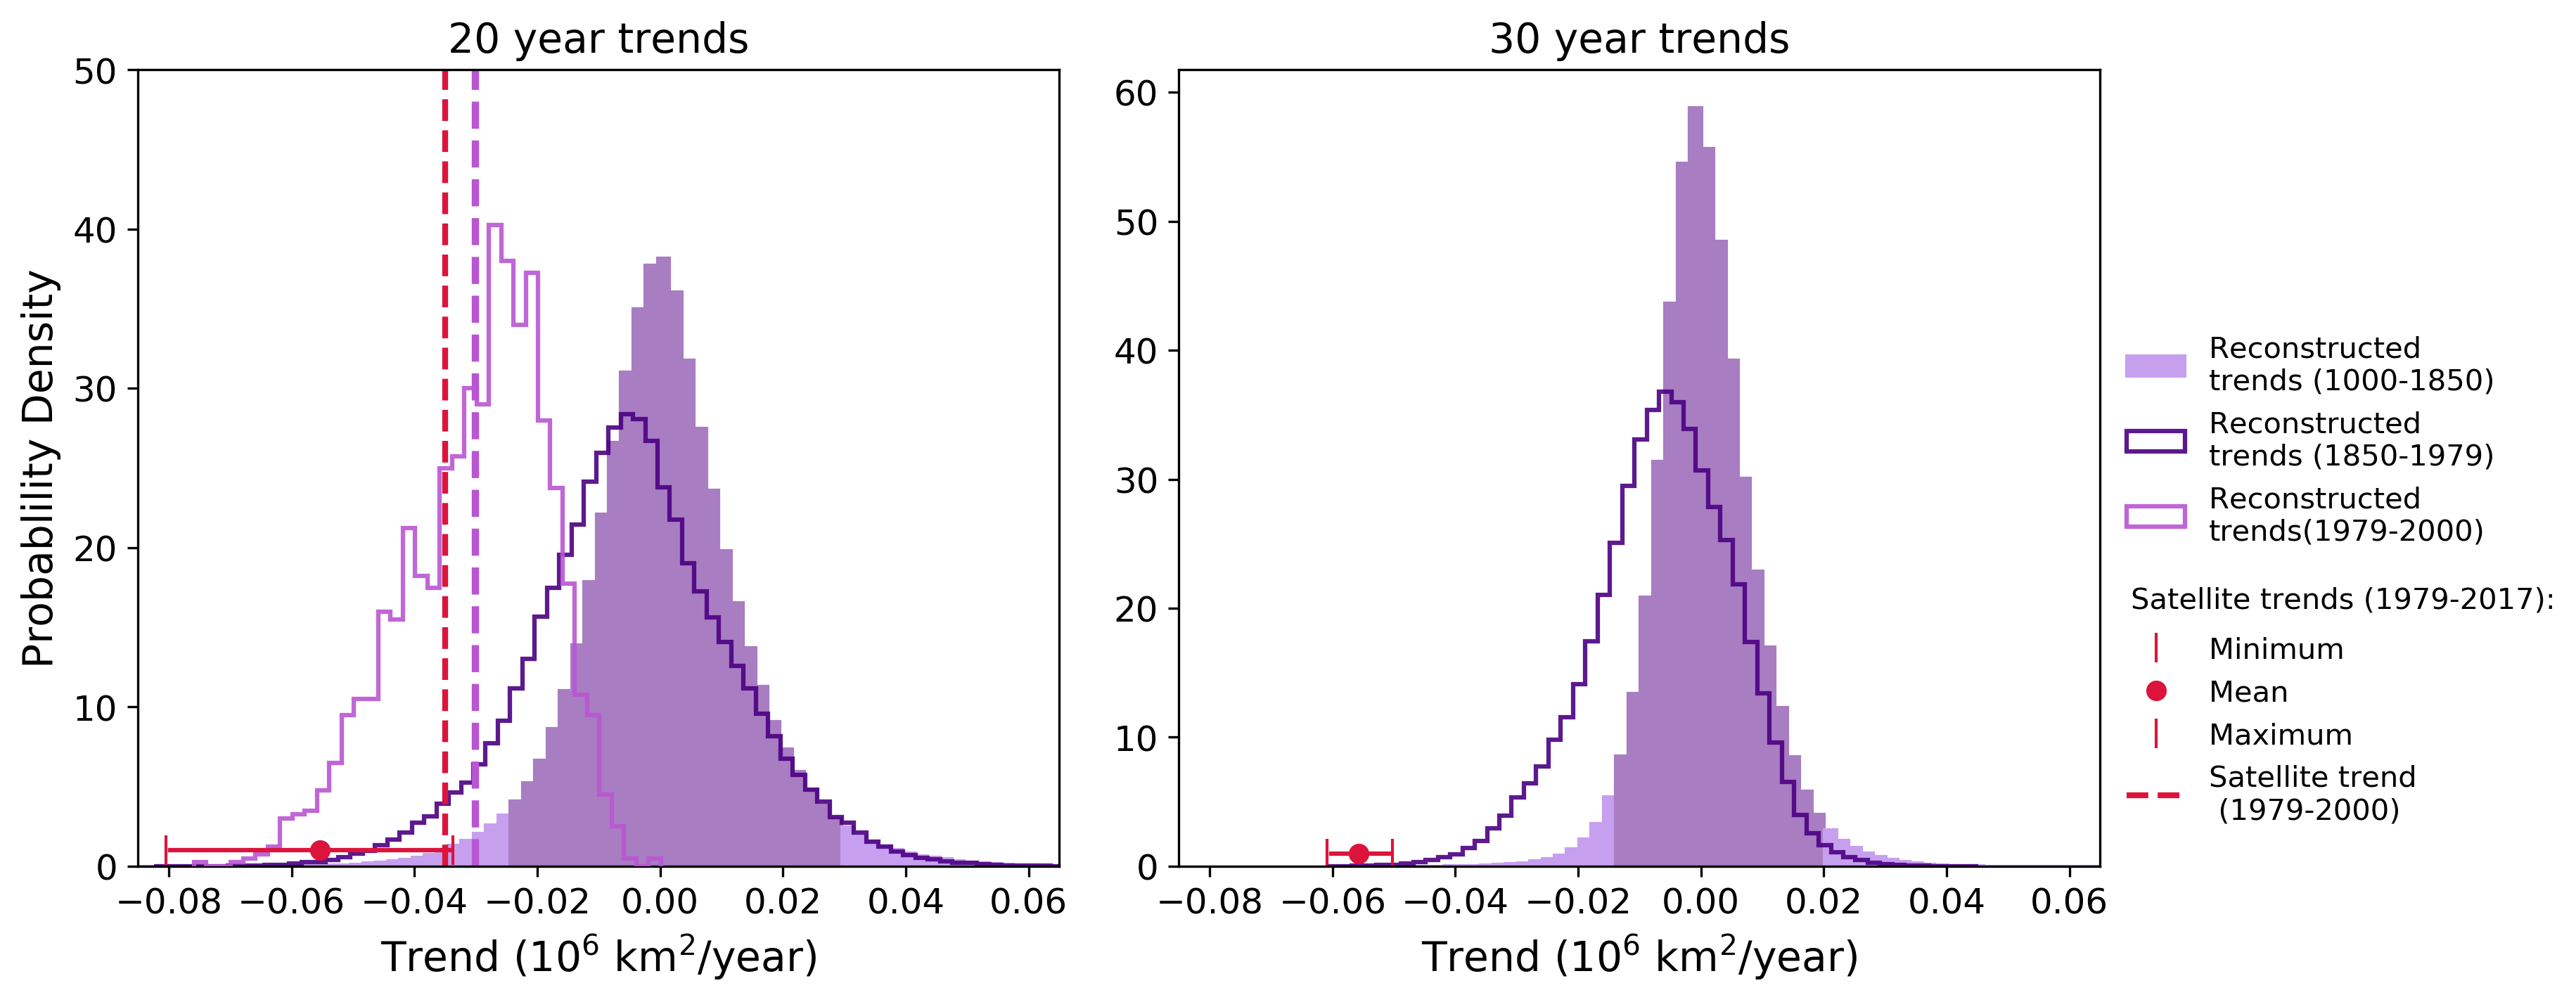

In [28]:
title1 = '20 year trends'
title2 = '30 year trends'
binwidth=0.002

fig, (ax_hist) = plt.subplots(1,2,figsize=(12,5))
ax_hist = ax_hist.flatten()

plot_hist_pre_post_sat_test(pre20_slope_all_endpts_mpi, post20_slope_all_endpts_mpi, 
                            sat20_slope_recon_mpi,2.5, 97.5, 1000, binwidth, ax_hist[0],
                            palette = 'purples',strends=True)
plot_hist_pre_post_sat_test(pre30_slope_all_endpts_mpi, post30_slope_all_endpts_mpi, 
                            np.zeros(30), 2.5, 97.5, 1000, binwidth, ax_hist[1],
                            palette = 'purples',strends=False)

ax_hist[0].plot(sat20_slope_all_endpts.mean(),30,marker=',',color='white',
                linestyle='None',label='  \n  ')
ax_hist[0].axvline(sat20_slope_79_00,color='crimson',linewidth=2,
                label='Satellite trend \n (1979-2000)',linestyle='--')
ax_hist[0].plot(sat20_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Mean ',zorder=5)
ax_hist[0].axhline(y=1,xmin=0.035,xmax=0.34,color='crimson',linewidth=1.5,zorder=4)
ax_hist[0].plot(sat20_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Minimum ')
ax_hist[0].plot(sat20_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=2, 
             label='Maximum ')

ax_hist[1].plot(sat30_slope_all_endpts.mean(),1,marker='o',color='crimson',
                linestyle='None',label='Satellite trend \n (1979-2000)')
ax_hist[1].axhline(y=1,xmin=0.165,xmax=0.23,color='crimson',linewidth=1.5)
ax_hist[1].plot(sat30_slope_all_endpts.min(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Minimum trend \nin satellite record \n (1992-2012)')
ax_hist[1].plot(sat30_slope_all_endpts.max(),1,marker='|', color='crimson',
             markersize=10,linestyle='None',linewidth=3, 
             label='Max trend \nin satellite record \n (1992-2012)')

ax_hist[0].set_ylabel('Probablility Density',fontsize=14)
ax_hist[0].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[0].set_xlim(-0.085,0.065)
ax_hist[0].set_ylim(0,50)
ax_hist[0].set_title(title1, fontsize=14)

#ax_hist[1].set_ylabel('Probablility Density',fontsize=14)
ax_hist[1].set_xlabel('Trend (10$^6$ km$^2$/year)', fontsize=14)
ax_hist[1].set_xlim(-0.085,0.065)
#ax_hist[1].set_ylim(0,50)
ax_hist[1].set_title(title2, fontsize=14)

ax_hist[0].tick_params(axis='both', which='major', labelsize=12)
ax_hist[1].tick_params(axis='both', which='major', labelsize=12)

handles,labels = ax_hist[0].get_legend_handles_labels()
labels = [labels[5], labels[6], labels[7], labels[0], labels[3], labels[2], labels[4], labels[1]]
handles = [handles[5], handles[6], handles[7], handles[0], handles[3], handles[2], handles[4], handles[1]]

plt.legend(handles,labels, bbox_to_anchor=(1.0, 0.7), frameon=False)

plt.text(0.07, 20,'Satellite trends (1979-2017):')

plt.subplots_adjust(wspace=0.13, hspace=0.0)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = '20_30_year_trends_mpi_shaded.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## At what chunk length do distributions deviatiate?

In [29]:
window_pre = np.arange(10,40,1)

pre_slope_mean = np.zeros(window_pre.shape[0])
pre_slope_max = np.zeros(window_pre.shape[0])
pre_slope_min = np.zeros(window_pre.shape[0])
pre_slope_p95 = np.zeros(window_pre.shape[0])
pre_slope_p5 = np.zeros(window_pre.shape[0])
pre_slope_p97_5 = np.zeros(window_pre.shape[0])
pre_slope_p2_5 = np.zeros(window_pre.shape[0])

for w,win in enumerate(window_pre): 
    print(str(w)+', '+str(win))
    # Pre-industrial 
    pre_slope_all_endpts_ccsm4 = calc_all_trends(win,1000,1850,sie_ccsm4_anom_2d,recon_years)

    pre_slope_mean[w] = np.nanmean(pre_slope_all_endpts_ccsm4)
    pre_slope_max[w] = pre_slope_all_endpts_ccsm4.max()
    pre_slope_min[w] = pre_slope_all_endpts_ccsm4.min()
    pre_slope_p95[w] = np.percentile(pre_slope_all_endpts_ccsm4,95)
    pre_slope_p97_5[w] = np.percentile(pre_slope_all_endpts_ccsm4,97.5)
    pre_slope_p2_5[w] = np.percentile(pre_slope_all_endpts_ccsm4,2.5)
    pre_slope_p5[w] = np.percentile(pre_slope_all_endpts_ccsm4,5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000


KeyboardInterrupt: 

In [24]:
save_dict = {}
save_dict['pre_slope_mean'] = pre_slope_mean
save_dict['pre_slope_max'] = pre_slope_max
save_dict['pre_slope_min'] = pre_slope_min
save_dict['pre_slope_p95'] = pre_slope_p95
save_dict['pre_slope_p5'] = pre_slope_p5
save_dict['pre_slope_p97_5'] = pre_slope_p97_5
save_dict['pre_slope_p2_5'] = pre_slope_p2_5

savedir = 'trends/'
savename = 'pre_ccsm4_slope_window_10_40.pkl'
print('Saving experiment to: ',savedir+savename)
#pickle.dump(save_dict,open(savedir+savename, "wb"))

Saving experiment to:  trends/pre_ccsm4_slope_window_10_40.pkl


In [29]:
window_pre = np.arange(10,40,1)

pre_mpi_slope_mean = np.zeros(window_pre.shape[0])
pre_mpi_slope_max = np.zeros(window_pre.shape[0])
pre_mpi_slope_min = np.zeros(window_pre.shape[0])
pre_mpi_slope_p97_5 = np.zeros(window_pre.shape[0])
pre_mpi_slope_p2_5 = np.zeros(window_pre.shape[0])

for w,win in enumerate(window_pre): 
    print(str(w)+', '+str(win))
    # Pre-industrial 
    pre_mpi_slope_all_endpts = calc_all_trends(win,1000,1850,sie_mpi_anom_2d,recon_years_mpi)

    pre_mpi_slope_mean[w] = np.nanmean(pre_mpi_slope_all_endpts)
    pre_mpi_slope_max[w] = pre_mpi_slope_all_endpts.max()
    pre_mpi_slope_min[w] = pre_mpi_slope_all_endpts.min()
    pre_mpi_slope_p97_5[w] = np.percentile(pre_mpi_slope_all_endpts,97.5)
    pre_mpi_slope_p2_5[w] = np.percentile(pre_mpi_slope_all_endpts,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [30]:
save_dict = {}
save_dict['pre_mpi_slope_mean'] = pre_mpi_slope_mean
save_dict['pre_mpi_slope_max'] = pre_mpi_slope_max
save_dict['pre_mpi_slope_min'] = pre_mpi_slope_min
save_dict['pre_mpi_slope_p97_5'] = pre_mpi_slope_p97_5
save_dict['pre_mpi_slope_p2_5'] = pre_mpi_slope_p2_5

savedir = 'trends/'
savename = 'pre_mpi_slope_window_10_40.pkl'
print('Saving experiment to: ',savedir+savename)
pickle.dump(save_dict,open(savedir+savename, "wb"))

Saving experiment to:  trends/pre_mpi_slope_window_10_40.pkl


In [25]:
window_post = np.arange(10,40,1)

post_slope_mean = np.zeros(window_post.shape[0])
post_slope_max = np.zeros(window_post.shape[0])
post_slope_min = np.zeros(window_post.shape[0])
post_slope_p95 = np.zeros(window_post.shape[0])
post_slope_p5 = np.zeros(window_post.shape[0])
post_slope_p97_5 = np.zeros(window_post.shape[0])
post_slope_p2_5 = np.zeros(window_post.shape[0])

for w,win in enumerate(window_post):    
    print(str(w)+', '+str(win))
    # Post-industrial range: 
    post_slope_all_endpts_ccsm4 = calc_all_trends(win,1850,1979,sie_ccsm4_anom_2d,recon_years)

    post_slope_mean[w] = np.nanmean(post_slope_all_endpts_ccsm4)
    post_slope_max[w] = post_slope_all_endpts_ccsm4.max()
    post_slope_min[w] = post_slope_all_endpts_ccsm4.min()
    post_slope_p95[w] = np.percentile(post_slope_all_endpts_ccsm4,95)
    post_slope_p97_5[w] = np.percentile(post_slope_all_endpts_ccsm4,97.5)
    post_slope_p2_5[w] = np.percentile(post_slope_all_endpts_ccsm4,2.5)
    post_slope_p5[w] = np.percentile(post_slope_all_endpts_ccsm4,5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [26]:
save_dict = {}
save_dict['post_slope_mean'] = post_slope_mean
save_dict['post_slope_max'] = post_slope_max
save_dict['post_slope_min'] = post_slope_min
save_dict['post_slope_p95'] = post_slope_p95
save_dict['post_slope_p5'] = post_slope_p5
save_dict['post_slope_p97_5'] = post_slope_p97_5
save_dict['post_slope_p2_5'] = post_slope_p2_5

savedir = 'trends/'
savename = 'post_ccsm4_slope_window_10_40.pkl'
print('Saving experiment to: ',savedir+savename)
#pickle.dump(save_dict,open(savedir+savename, "wb"))

Saving experiment to:  trends/post_ccsm4_slope_window_10_40.pkl


In [27]:
window_post = np.arange(10,40,1)

post_mpi_slope_mean = np.zeros(window_post.shape[0])
post_mpi_slope_max = np.zeros(window_post.shape[0])
post_mpi_slope_min = np.zeros(window_post.shape[0])
post_mpi_slope_p97_5 = np.zeros(window_post.shape[0])
post_mpi_slope_p2_5 = np.zeros(window_post.shape[0])

for w,win in enumerate(window_post):    
    print(str(w)+', '+str(win))
    # Post-industrial range: 
    post_mpi_slope_all_endpts = calc_all_trends(win,1850,1979,sie_mpi_anom_2d,recon_years_mpi)
        
    post_mpi_slope_mean[w] = np.nanmean(post_mpi_slope_all_endpts)
    post_mpi_slope_max[w] = post_mpi_slope_all_endpts.max()
    post_mpi_slope_min[w] = post_mpi_slope_all_endpts.min()
    post_mpi_slope_p97_5[w] = np.percentile(post_mpi_slope_all_endpts,97.5)
    post_mpi_slope_p2_5[w] = np.percentile(post_mpi_slope_all_endpts,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [28]:
save_dict = {}
save_dict['post_mpi_slope_mean'] = post_mpi_slope_mean
save_dict['post_mpi_slope_max'] = post_mpi_slope_max
save_dict['post_mpi_slope_min'] = post_mpi_slope_min
save_dict['post_mpi_slope_p97_5'] = post_mpi_slope_p97_5
save_dict['post_mpi_slope_p2_5'] = post_mpi_slope_p2_5

savedir = 'trends/'
savename = 'post_mpi_slope_window_10_40.pkl'
print('Saving experiment to: ',savedir+savename)
#pickle.dump(save_dict,open(savedir+savename, "wb"))

Saving experiment to:  trends/post_mpi_slope_window_10_40.pkl


In [31]:
window_sat_recon = np.arange(10,21,1)

sat_recon_slope_mean = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_max = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_min = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p95 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p5 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p97_5 = np.zeros(window_sat_recon.shape[0])
sat_recon_slope_p2_5 = np.zeros(window_sat_recon.shape[0])

#slope_sat_recon_ccsm4 = np.zeros((window_sat_recon.shape[0],2000))

for w,win in enumerate(window_sat_recon):
    print(str(w)+', '+str(win))
    slope_sat_recon_ccsm4 = calc_all_trends(win,1979,2000,sie_ccsm4_anom_2d,recon_years)

    sat_recon_slope_mean[w] = np.nanmean(slope_sat_recon_ccsm4)
    sat_recon_slope_max[w] = slope_sat_recon_ccsm4.max()
    sat_recon_slope_min[w] = slope_sat_recon_ccsm4.min()
    sat_recon_slope_p95[w] = np.percentile(slope_sat_recon_ccsm4,95)
    sat_recon_slope_p5[w] = np.percentile(slope_sat_recon_ccsm4,5)
    sat_recon_slope_p97_5[w] = np.percentile(slope_sat_recon_ccsm4,97.5)
    sat_recon_slope_p2_5[w] = np.percentile(slope_sat_recon_ccsm4,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [32]:
window_sat_recon = np.arange(10,21,1)

sat_recon_mpi_slope_mean = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_max = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_min = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p95 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p5 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p97_5 = np.zeros(window_sat_recon.shape[0])
sat_recon_mpi_slope_p2_5 = np.zeros(window_sat_recon.shape[0])

#slope_sat_recon_ccsm4 = np.zeros((window_sat_recon.shape[0],2000))

for w,win in enumerate(window_sat_recon):
    print(str(w)+', '+str(win))
    slope_sat_recon_mpi = calc_all_trends(win,1979,2000,sie_mpi_anom_2d,recon_years_mpi)

    sat_recon_mpi_slope_mean[w] = np.nanmean(slope_sat_recon_mpi)
    sat_recon_mpi_slope_max[w] = slope_sat_recon_mpi.max()
    sat_recon_mpi_slope_min[w] = slope_sat_recon_mpi.min()
    sat_recon_mpi_slope_p95[w] = np.percentile(slope_sat_recon_mpi,95)
    sat_recon_mpi_slope_p5[w] = np.percentile(slope_sat_recon_mpi,5)
    sat_recon_mpi_slope_p97_5[w] = np.percentile(slope_sat_recon_mpi,97.5)
    sat_recon_mpi_slope_p2_5[w] = np.percentile(slope_sat_recon_mpi,2.5)

0, 10
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
1, 11
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
2, 12
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 2000
1900 of 2000
3, 13
0 of 2000
100 of 2000
200 of 2000
300 of 2000
400 of 2000
500 of 2000
600 of 2000
700 of 2000
800 of 2000
900 of 2000
1000 of 2000
1100 of 2000
1200 of 2000
1300 of 2000
1400 of 2000
1500 of 2000
1600 of 2000
1700 of 2000
1800 of 20

In [20]:
window = np.arange(10,38,1)

sat_slope_mean = np.zeros(window.shape[0])
sat_slope_max = np.zeros(window.shape[0])
sat_slope_min = np.zeros(window.shape[0])
sat_slope_p95 = np.zeros(window.shape[0])
sat_slope_p5 = np.zeros(window.shape[0])
sat_slope_p97_5 = np.zeros(window.shape[0])
sat_slope_p2_5 = np.zeros(window.shape[0])

for w,win in enumerate(window): 
    print(str(w)+', '+str(win))
    # Satellite range: 
    sat_range_start = np.arange(1979,2017-win,1)
    sat_range_end = np.arange(1979+win,2017,1)

    # Calc possible trends satellite era: -----------------------------
    sat_slope_all_endpts = np.zeros(len(sat_range_start))

    for t,time in enumerate(sat_range_start):
        sat_slope_all_endpts[t] = rrutils.find_trend(fet_sie_anom,fet_time,
                                                     sat_range_start[t],sat_range_end[t])

    sat_slope_mean[w] = np.nanmean(sat_slope_all_endpts)
    sat_slope_max[w] = sat_slope_all_endpts.max()
    sat_slope_min[w] = sat_slope_all_endpts.min()
    sat_slope_p95[w] = np.percentile(sat_slope_all_endpts,95)
    sat_slope_p5[w] = np.percentile(sat_slope_all_endpts,5)
    sat_slope_p97_5[w] = np.percentile(sat_slope_all_endpts,97.5)
    sat_slope_p2_5[w] = np.percentile(sat_slope_all_endpts,2.5)

0, 10
1, 11
2, 12
3, 13
4, 14
5, 15
6, 16
7, 17
8, 18
9, 19
10, 20
11, 21
12, 22
13, 23
14, 24
15, 25
16, 26
17, 27
18, 28
19, 29
20, 30
21, 31
22, 32
23, 33
24, 34
25, 35
26, 36
27, 37


In [22]:
save_dict = {}
save_dict['sat_slope_mean'] = sat_slope_mean
save_dict['sat_slope_max'] = sat_slope_max
save_dict['sat_slope_min'] = sat_slope_min
save_dict['sat_slope_p95'] = sat_slope_p95
save_dict['sat_slope_p5'] = sat_slope_p5
save_dict['sat_slope_p97_5'] = sat_slope_p97_5
save_dict['sat_slope_p2_5'] = sat_slope_p2_5

savedir = 'trends/'
savename = 'sat_slope_window_10_38.pkl'
# print('Saving experiment to: ',savedir+savename)
# pickle.dump(save_dict,open(savedir+savename, "wb"))

Saving experiment to:  trends/sat_slope_window_10_38.pkl


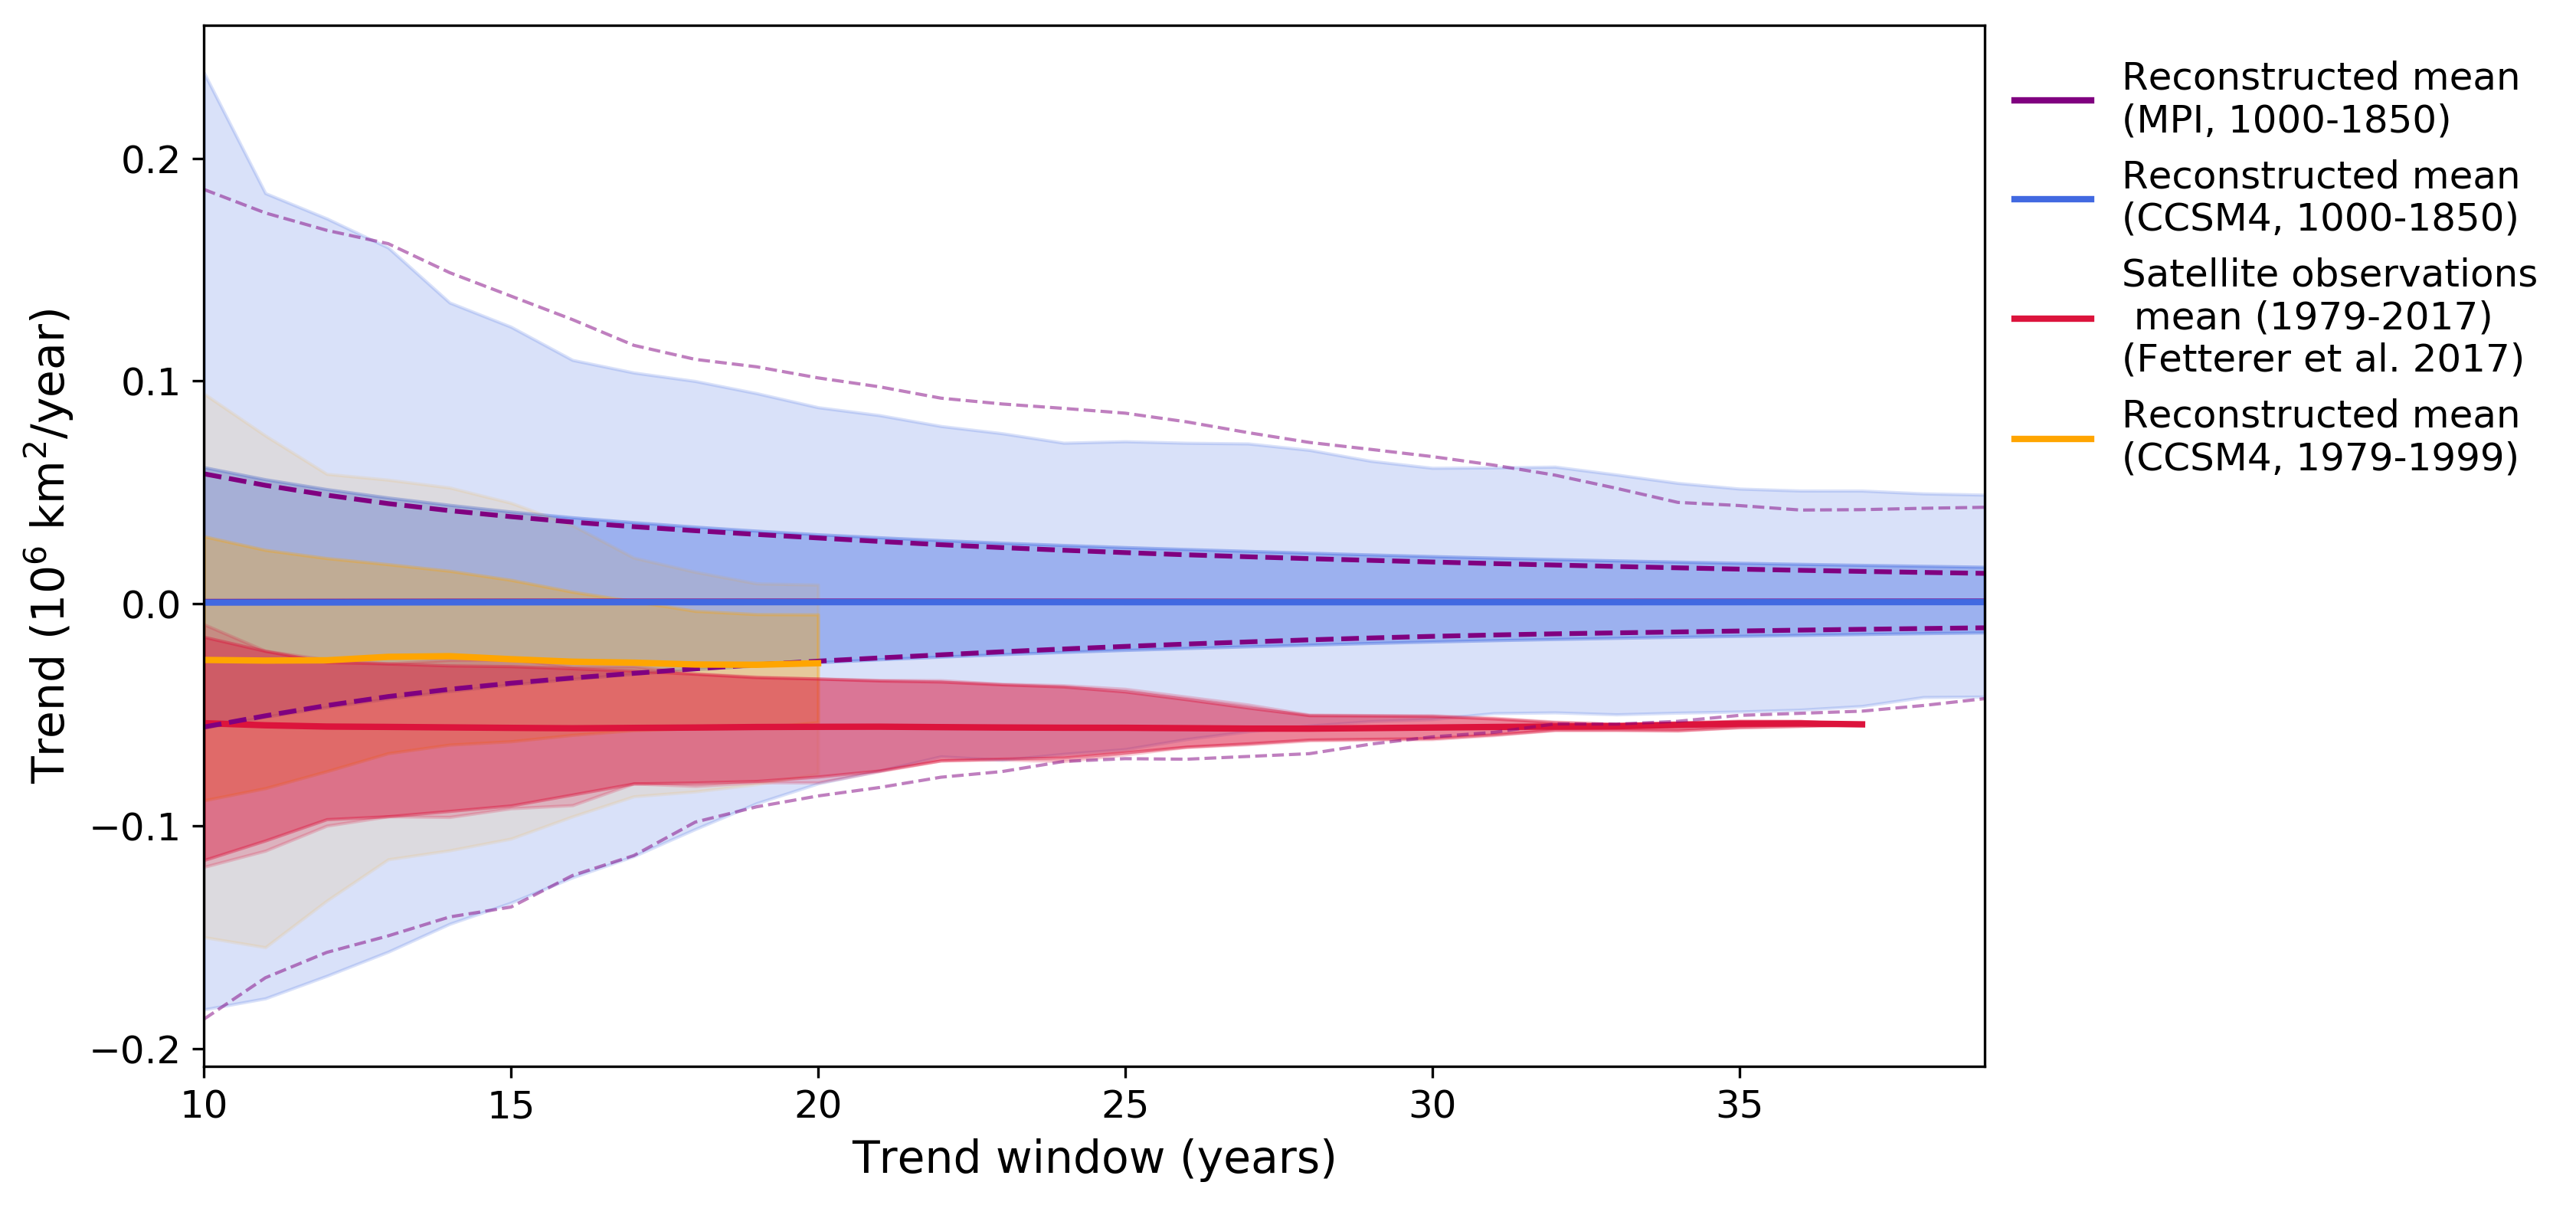

In [38]:
window_prior = np.arange(10,40,1)

plt.figure(figsize=(10,6))

plt.plot(window_prior, pre_mpi_slope_mean,linewidth=2, color='purple', 
         label='Reconstructed mean \n(MPI, 1000-1850)')
plt.plot(window_pre, pre_slope_mean,linewidth=2, color='royalblue', 
         label='Reconstructed mean \n(CCSM4, 1000-1850)')
plt.plot(window, sat_slope_mean,linewidth=2, color='crimson', 
         label='Satellite observations\n mean (1979-2017) \n(Fetterer et al. 2017)')

plt.plot(window_prior, pre_mpi_slope_p2_5,linewidth=1.5,linestyle = '--', color='purple')
plt.plot(window_prior, pre_mpi_slope_p97_5,linewidth=1.5,linestyle = '--', color='purple')

plt.plot(window_prior, pre_mpi_slope_min,linewidth=1,linestyle = '--', color='purple', alpha=0.5)
plt.plot(window_prior, pre_mpi_slope_max,linewidth=1,linestyle = '--', color='purple', alpha=0.5)

plt.plot(window_sat_recon, sat_recon_slope_mean,linewidth=2, color='orange', 
         label='Reconstructed mean \n(CCSM4, 1979-1999)')

plt.fill_between(window_pre,pre_slope_min, pre_slope_max, color='royalblue', alpha=0.2)

plt.fill_between(window_pre,pre_slope_p2_5, pre_slope_p97_5, color='royalblue', 
                 alpha=0.4)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window_sat_recon,sat_recon_slope_p2_5, sat_recon_slope_p97_5,
                 color='orange', alpha=0.3)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window_sat_recon,sat_recon_slope_min, sat_recon_slope_max,
                 color='orange', alpha=0.1)#, label='2.5th and 97.5th \npercentiles')
plt.fill_between(window,sat_slope_p2_5, sat_slope_p97_5, color='crimson', 
                 alpha=0.4)#,label='2.5th and 97.5th \npercentiles')
plt.fill_between(window,sat_slope_min, sat_slope_max, color='crimson', 
                 alpha=0.2)#,label='2.5th and 97.5th \npercentiles')

plt.xlabel('Trend window (years)', fontsize=14)
plt.ylabel('Trend (10$^6$ km$^2$/year)', fontsize=14)

plt.legend(fontsize=12, bbox_to_anchor=(0.83, 0.5, 0.5, 0.5), frameon=False)
plt.xticks(np.arange(10,40,5))
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(10, 39)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Window_trends_10_40_ccsm4_mpi.png'
#plt.savefig(savedir+savename, bbox_inches='tight')